# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*



The idea of this Project is to automatically retrieve structured data from pages [rtvslo.si](https://www.rtvslo.si).

## Environment setup

To setup environment we first need to install conda. Conda can be downloaded from: https://docs.conda.io/projects/conda/en/latest/user-guide/install/download.html . Then we need to make new evironment. I used name "upv-project_1" but it can be arbitrary name. Use commands from below to setup environment. 

`ENVIRONMENT SETUP DESCRIPTIONS:
conda create --name upv-project_1
conda activate upv-project_1
conda install python
conda install selenium
conda install jupyter notebook
ipython kernel install --name "upv-project_1" --user
conda install pandas
conda install requests
conda install numpy
conda install matplotlib
conda install scipy
conda install seaborn`

## Web scraping

We will scrape all whole pages until 1000th article with search key "koronavirus" from  [rtvslo.si](https://www.rtvslo.si) and save data in JSON format.


JSON Schema:

```
[
  {
    "author": ["author_1", "author_2",...],
    "day_published": "DD.MM.YYYY",
    "changed_later": "YES"/"NO", 
    "title": "article_title",
    "subtitle": "article_subtitle",
    "tags": ["tag_1", "tag_2",...],
    "section_tag": "section_tag"
    "content": "article_text",
    "comments": [
        {
            "user": "user_name",
            "date_hour": ["DD.MM.YYYY"; "HH:MM"],
            "grade": comment_grade(int),
            "reply": "YES"/"NO",
            "comment": "comment_text",

        },...
    ],
    "hour_published": "HH:MM"
    
  }, 
  {
    ...
]


```


In block below are listed all libraries and helper functions needed. Helper functions are imported from helper_f.py file.

In [1]:
# Load all the libraries needed for running the code chunks below

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import os
from selenium.webdriver.common.by import By
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.pyplot import figure


from helper_f import links,  get_article_data,  get_article_comments,  edit_and_join, get_data_skit, get_data_dostopno, get_data_enostavno, make_json_format, change_day_published


19


First we need to get urls of all articles. Function "links" simulates typing search key "koronavirus" in search bar and navigates trough pages and collects urls of most recent articles and saves them into file "article_urls.txt". Every time we run it we can get new different urls. It is commented so you can't accidentaly overwrite existing urls used in visualizations. If you want to get new urls uncomment and run block. It is better not to collect urls again but to delete some of allready scraped data from folder json and script in notebook will detect that they are missing and scrape data again from already collected urls.  

In [2]:
#COMMENTED TO CAN NOT ACCIDENTALY OVERWRITE URLS WITH  NEW, MORE RECENT ONES.

main_URL = "https://www.rtvslo.si"
num = 1000 #number of articles, max on rtvslo is 1000
main_key = "Koronavirus"


#links(main_URL, main_key, num) #get 1000 article urls for search key "Koronavirus" and write it into article_urls.txt file


Now we can read url by url from "article_urls.txt" file. I divided urls in 4 categories, based on webpage style and features. Majority of web pages are in let's say normal rtvslo article format (those also can have comments). But some of them are in others "SKIT", "ENOSTAVNO" and "DOSTOPNO" cathegory. Each of them have unique code pattern. Pages will be scraped depending on cathegory by functions: get_article_data (for normal articles), get_data_skit, get_data_dostopno and get_data_enostavno. Comments from "normal" rtvslo articles wil be collected with function get_article_comments. Data from each article will be saved in its own .json file in json folder, with make_json_format function . Before scraping each article, script will check whether article has already been scraped or not. So in case of some interuption it wont need to start from beginning again. 

In [3]:
data = []
data_urls = [] #normal rtvslo articles with no SKIT, ENOSTAVNO, DOSTOPNO articles

enostavno = []
skit = []
dostopno = []
i = 0
print("Started scraping")
file = open('article_urls.txt', 'r', encoding='utf-8')
lines = file.readlines()
for line in lines: #urls 
    if "/enostavno/" in line:
        enostavno.append(line[:-1])
    elif "/skit/" in line:
        skit.append(line[:-1]) #\n has to be removed
    elif "/dostopno/" in line:
        dostopno.append(line[:-1])
    else: #normal ones
        data_urls.append(line[:-1])
        #print("Starting to write url number ", )

        
u = len(data_urls)
s = len(skit)
d = len(dostopno)
e = len(enostavno)
        
for j in range(u): #len data_urls
    if os.path.isfile('json/{}.json'.format(j)): #check if article data was already scraped
        pass
    else: #get article and comments data

        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text) = get_article_data(data_urls[j])
        comments = get_article_comments(data_urls[j])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(j), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("end of main scraping...")


for i in range(s): #len skit
    if os.path.isfile('json/{}.json'.format(u + i)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_skit(skit[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("end of SKIT articles scraping...")




for i in range(d):
    if os.path.isfile('json/{}.json'.format(u + s + i)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_dostopno(dostopno[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u + s), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("end of DOSTOPNO articles scraping...")


for i in range(e):
    if os.path.isfile('json/{}.json'.format(u + s + i + d)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_enostavno(enostavno[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u + s + d), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("end of ENOSTAVNO articles scraping...")



        
    

Started scraping
end of main scraping...
end of SKIT articles scraping...
end of DOSTOPNO articles scraping...
end of ENOSTAVNO articles scraping...


It takes a lot of time to scrape all the data. I found some typing mistakes but decided not to scrape again but to fix already scraped data. Function in block below edit each .json file and then saves it into folder edited_json_files. It also merges all edited files togather into one big file called data.json. 

In [4]:
edit_and_join() #fix typos and join all single article json files into one big json file with all the data.
print("Json files fixed and joined into data.json file.")

Json files fixed and joined into data.json file.


## Basic summarization

Prepare and show at least five basic visualizations of the extracted data as presented in the chapter *Summarizing data - the basics* of the course's e-book. Explain each visualization of the data.

In [5]:
#load json file
data_file =  open('data.json', "r", encoding='utf-8')
data = json.load(data_file)#data
data_file.close()

df = pd.json_normalize(data) #open it with pandas; latter shown that it was not the best idea
#df.head()#test




### Visualization 1

In [6]:
#data for visualization 1 and some changes in date format
df['day'] = pd.to_datetime(df['day_published'], format='%d.%m.%Y') #convert date format to more useful pandas format

nm_words = [] #word count
for d in df["content"]:
    ct = len(d.split(" "))
    #print(ct)
    nm_words.append(ct)
    
df["word_number"] = nm_words

nm_comments = [] #comment words count
for d in df["comments"]:
    nm_comments.append(len(d))

df["comment_number"] = nm_comments

df.head()

df1 = df[["day", "changed_later"]]
data1 = df1.sort_values('day').set_index('day')
week_groups_resample = data1.resample('W').count()



df2 = df[["day"]]
df2["day_name"] = df['day'].dt.day_name()
#df3 = df2.groupby("day_name").count()
#df3.plot(kind = "barh", legend=None)


df3 = df2[["day_name"]]
df3['day_name'] = pd.Categorical(df3['day_name'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

counts = df3["day_name"].value_counts()
sorted_by_day_name = counts.sort_index()


C:\Users\zaloz\AppData\Local\Temp/ipykernel_1492/443227529.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["day_name"] = df['day'].dt.day_name()
C:\Users\zaloz\AppData\Local\Temp/ipykernel_1492/443227529.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['day_name'] = pd.Categorical(df3['day_name'], categories=


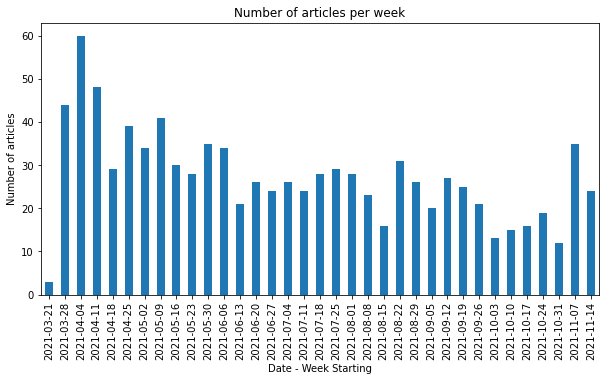

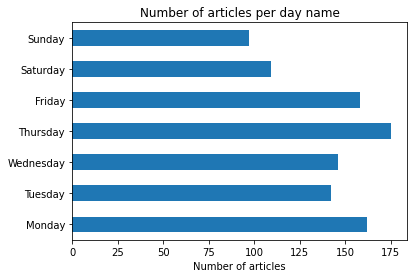

In [7]:
ax = week_groups_resample.plot(kind='bar',
                               figsize=(10,5),legend=None)
ax.set_xticklabels(week_groups_resample.index.strftime('%Y-%m-%d'), rotation=90)
plt.xlabel('Date - Week Starting');
plt.ylabel('Number of articles');
plt.title("Number of articles per week")
plt.show()


sorted_by_day_name.plot(kind='barh')
plt.title('Number of articles per day name')
plt.ylabel('')
plt.xlabel('Number of articles')
plt.show()

In visualization 1 we have 2 plots. Both are bar plots. First is showing number of articles published in each week. Dates are in format YYYY-MM-DD. I was wondering if there is any correlation between epidemic situation and number of articles. And we can see, that in april and may when there were more covid cases in Slovenia, then were also more articles published about covid. 
Second plot is showing number of articles per every day of week. We see that at weekends article authors were less active with publishing.

### Visualization 2



In [9]:
#data for visualization 2 and 3
article_lengths = []
comm_date = []
comm_time = [] #only full hours
comm_lengths = []
good_comm = []
not_replies = []
for article in data:
    article_lengths.append(len(article["content"].split(" ")))
    
    for comm in article["comments"]:
        date, time = comm["date_hour"]
        comm_date.append(date)
        comm_time.append(time)
        length = len(comm["comment"].split(" "))
        comm_lengths.append(length)
        if int(comm["grade"]) > 20:
            good_comm.append(length)

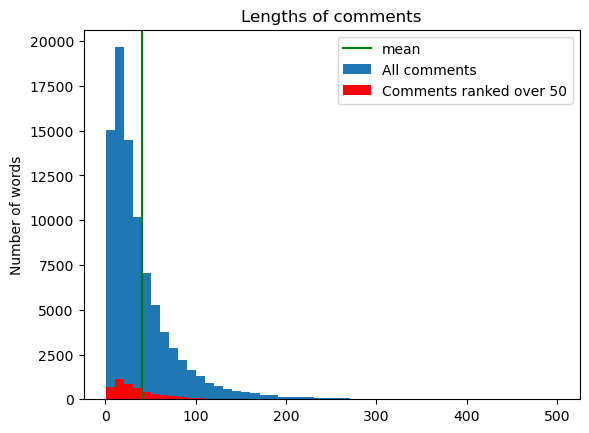

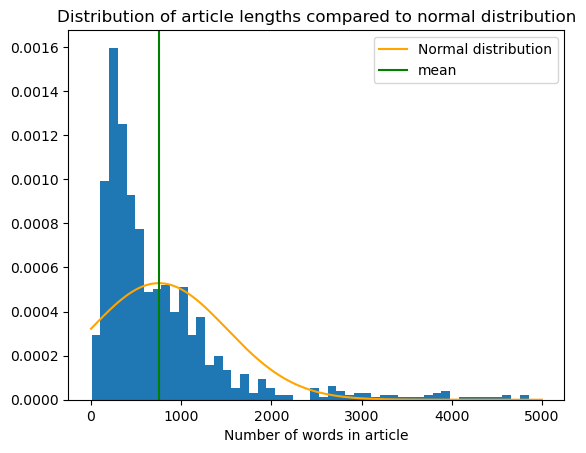

In [21]:
#code 
plt.figure()
comm_mean = np.mean(comm_lengths)
plt.hist(comm_lengths, bins = 50, range=(1,500), density=False, label="All comments")
comm_std = np.std(comm_lengths)
X = np.linspace(0,500, 1000)
#plt.plot(X, stats.norm.pdf(X, comm_mean, comm_std), label = "Normal distribution")
plt.axvline(x=comm_mean, color="green", label= "mean")
#plt.axvline(x=np.mean(good_comm), color="green", label= "mean")
plt.hist(good_comm, bins=50, density=False, color="red",  range=(1,500), label="Comments ranked over 50")
plt.title("Lengths of comments")
plt.ylabel('Number of words')
plt.legend()
plt.show()


art_std = np.std(article_lengths)
art_mean = np.mean(article_lengths)

plt.figure()
X = np.linspace(1,5000,1000)
plt.plot(X, stats.norm.pdf(X, art_mean, art_std), label = "Normal distribution", color="orange")
plt.axvline(x=art_mean, color="green", label= "mean")
plt.hist(article_lengths, bins=50, density=True, )
plt.ylabel('')
plt.xlabel('Number of words in article')
plt.legend()
plt.title("Distribution of article lengths compared to normal distribution")
plt.show()


In visualization 2 there are 2 plots. First if showing length of comments in number of words. All comments are marked blue and comments with ranking over 50 are marked in red. Vertical green line is showing mean number of words in comments.

Plot 2 is showing distribution of numbers of words in articles. I thought that maybe it could be normall distributet so I also plotted belonging normall distribution but they do not match.  

### Visualization 3



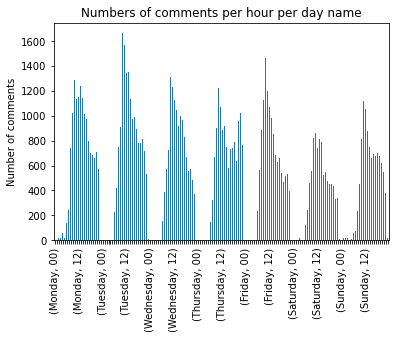

In [12]:
plot_5 = pd.DataFrame(list(zip(comm_date, comm_time)),
               columns =['day', 'hour'])

plot_5["hour"] = plot_5['hour'].apply(lambda x: x[:2])
plot_5['day'] = pd.to_datetime(plot_5['day'], format='%d.%m.%Y')
plot_5_f= plot_5[['hour']]  
plot_5_f['day_name'] = plot_5['day'].dt.day_name()
plot_5_f['day_name'] = pd.Categorical(plot_5_f['day_name'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
   ordered=True)

plot_5_f.set_index('day_name')
plot_data = plot_5_f.groupby(["day_name", "hour"]).size()


fig, ax = plt.subplots()



plot_data.plot(kind="bar", title=("Numbers of comments per hour per day name"))

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel("")
plt.ylabel("Number of comments")
plt.show()




In this plot I showed number of comments per hour in each day of week. We can see that users are less active at weekends, Surprisingly users are by far most active on Tuesdays. We can also see, that users comment the most around noon rather than after noon. This is surprising taking into account that most of people are at work in this time of day.

### Visualization 4



In [14]:
# Visualization 4 code
all_authors = []
d = {}
for article in data:
    changed = article["changed_later"]
    authors = article["author"]
    if authors != None:
        for author in authors:
            if len(author) > 1: #probably typos in articles and empty spaces
                if author not in all_authors:
                    all_authors.append(author)
                    if changed == "YES":
                        d[author] = (1,0)
                    else:
                        d[author] = (0,1)
                else:
                    (y,n) = d[author]
                    if changed == "YES":
                        d[author] = (y+1,n)
                    else:
                        d[author] = (y,n+y)
all_A = [(d[author][0] + d[author][1],author)  for author in all_authors if d[author][0] + d[author][1] > 10] #only authors with more than 10 articles
all_A.sort(reverse=True)

all_authors = [A for n, A in all_A]



labels = all_authors
yes = []
no = []
for author in all_authors:
    yes.append(d[author][0])
    no.append(d[author][1])
    

C:\Users\zaloz\AppData\Local\Temp/ipykernel_1492/2802811040.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, minor=False, rotation=90)


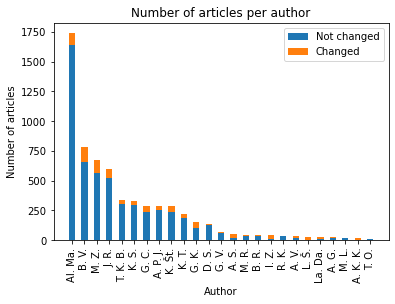

In [15]:

width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, no, width, label='Not changed')
ax.bar(labels, yes, width, bottom=no,
       label='Changed')

ax.set_ylabel('Number of articles')
ax.set_xlabel('Author')
ax.set_title('Number of articles per author')
ax.set_xticklabels(labels, minor=False, rotation=90)

ax.legend()

plt.show()

In visualization 4 we can see number of cuntributions by each author. I dropped all authors with less than 10 articles. In orange is marked part of articles by each author that was changed after publishing. We can see some big differents in number of cuntributions between authors. I assume some authors are more focused on articles about coronavirus then others.

### Visualization 5


In [16]:

num_comments = df["comment_number"] 
len_text = df["word_number"]
d_f= df[df["comment_number"] > 50]
#d_f.plot.scatter('word_number', "comment_number")

a=(list(d_f["author"]))
nm_authors = [len(sub_list) for sub_list in a]

d_f.insert(2, "nm_authors", nm_authors, True)
d_f_scatter = d_f[["nm_authors", "word_number", "comment_number"]]

print("max number of authors at single article is: ",max(nm_authors))



max number of authors at single article is:  5


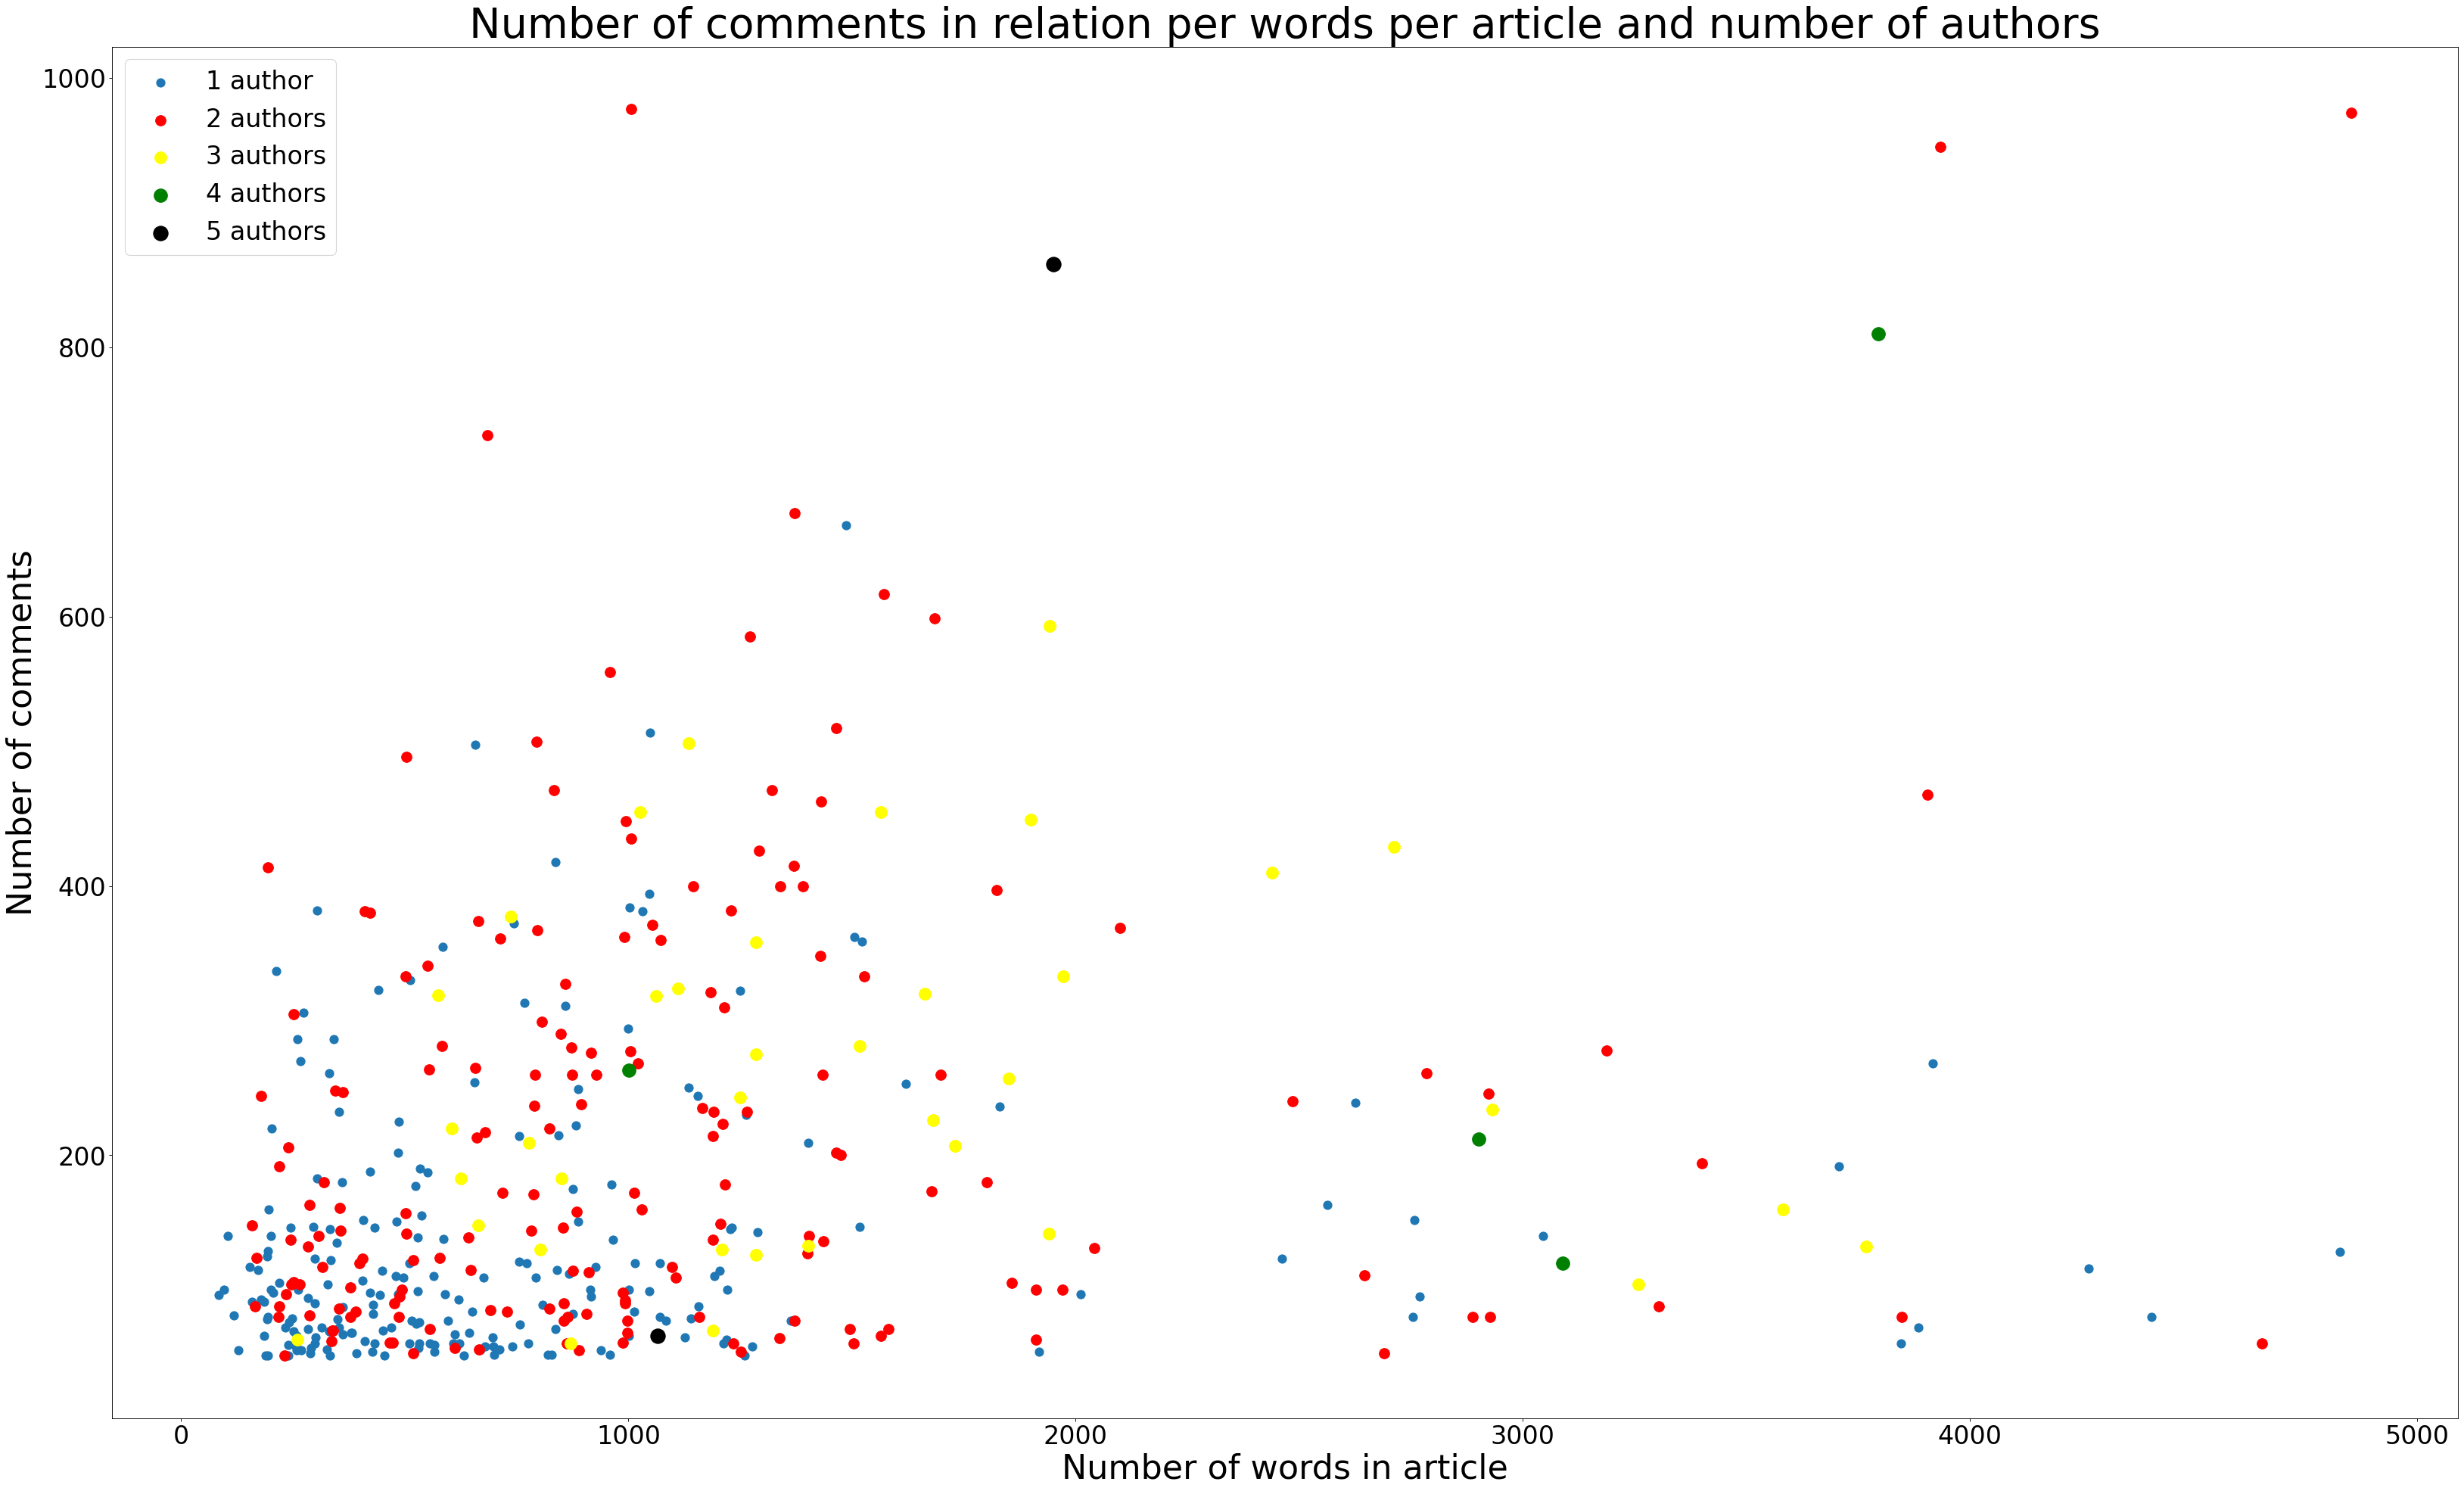

nm_authors  word_number  comment_number
nm_authors        1.000000     0.284336        0.341142
word_number       0.284336     1.000000        0.259933
comment_number    0.341142     0.259933        1.000000

In [17]:
plt.rcParams['xtick.labelsize'] = 30 
plt.rcParams['ytick.labelsize'] = 30 
scatter_1 = d_f_scatter[d_f_scatter["nm_authors"] == 1]
scatter_2 = d_f_scatter[d_f_scatter["nm_authors"] == 2]
scatter_3 = d_f_scatter[d_f_scatter["nm_authors"] == 3]
scatter_4 = d_f_scatter[d_f_scatter["nm_authors"] == 4]
scatter_5 = d_f_scatter[d_f_scatter["nm_authors"] == 5]
figure(figsize=(50, 30), dpi=80)
plt.scatter(scatter_1['word_number'], scatter_1["comment_number"], s = 100, label="1 author")
plt.scatter(scatter_2['word_number'], scatter_2["comment_number"], c="red", s = 150, label="2 authors")
plt.scatter(scatter_3['word_number'], scatter_3["comment_number"], c="yellow", s = 200, label = "3 authors")
plt.scatter(scatter_4['word_number'], scatter_4["comment_number"], c="green", s = 250, label = "4 authors")
plt.scatter(scatter_5['word_number'], scatter_5["comment_number"], c="black", s=300, label="5 authors")

plt.title("Number of comments in relation per words per article and number of authors", fontsize=50)
plt.xlabel("Number of words in article", fontsize = 40)
plt.ylabel("Number of comments", fontsize = 40)
plt.legend(fontsize=30)

 
plt.show()

plt.rcParams.update(plt.rcParamsDefault)
d_f_scatter.corr()

In vizualisation 5 are presented all articles in scatter plot. On x-axis is number of words in article and on y-axis is number of comments in this article. Every article is shown as point. Color and size are showing number of authors in single article. I was wondering if there is any correlation between number of authors, length of article and number of comment but it can not be seen clearly from this scatter plot. So i also calculated correlation table of those 3 data from where we can see light correlation between attributes.